(2,)
        Feature  Coefficient  Absolute_Coefficient
0  Junior_col_%     0.048915              0.048915
1  University_%     0.133777              0.133777
        Feature  Coefficient  Absolute_Coefficient
1  University_%     0.133777              0.133777
0  Junior_col_%     0.048915              0.048915


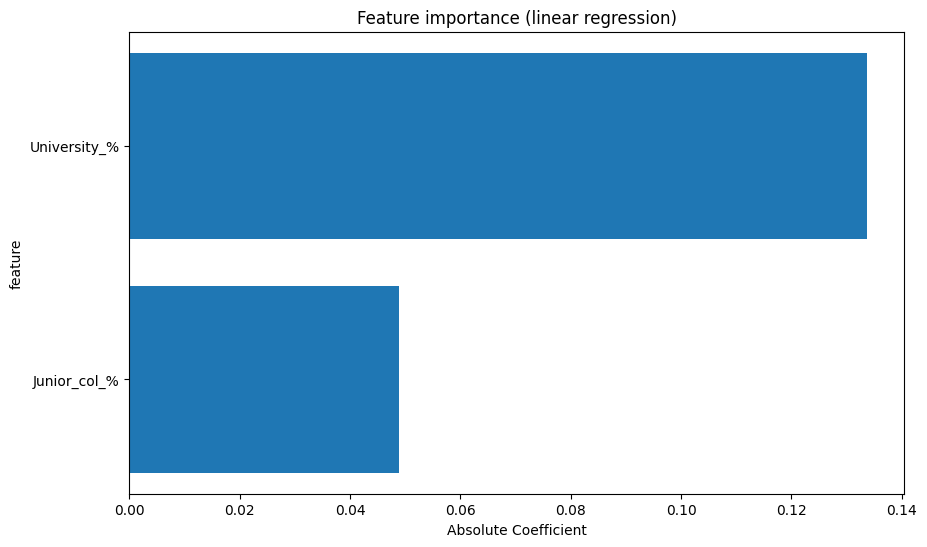

In [119]:
#Coefficient magintude ranking for linear regression
import pandas as pd
import matplotlib.pyplot as plt 
import joblib
#Plot feature importance
#Load the trained model
rfe=joblib.load("../models/model_v_best.pkl")
model=rfe.estimator_
#retrieve coefficients
coefficients=model.coef_
features=[
    'Junior_col_%', 'University_%'
]
#coefficient needs to be 1D 
coefficients=coefficients.flatten()
print(coefficients.shape)

#Combine in a dataframe for better readability
importance_df=pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
})
importance_df["Absolute_Coefficient"]=importance_df["Coefficient"].abs()
print(importance_df)
#Sorting coefficients by order of magnitude for Dataframes
importance_df=importance_df.sort_values(by="Absolute_Coefficient", ascending=False)
print(importance_df)
#visualize feature importance using bar plot 
plt.figure(figsize=(10,6))
plt.barh(importance_df["Feature"], importance_df["Absolute_Coefficient"])
plt.xlabel("Absolute Coefficient")
plt.ylabel("feature")
plt.title("Feature importance (linear regression)")
plt.gca().invert_yaxis()
plt.show()


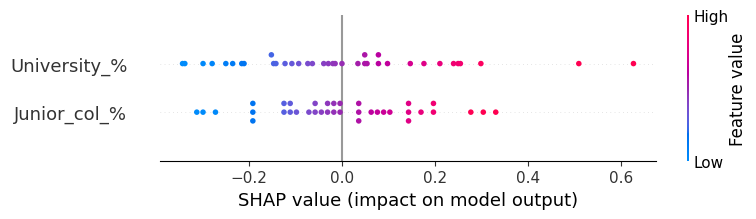

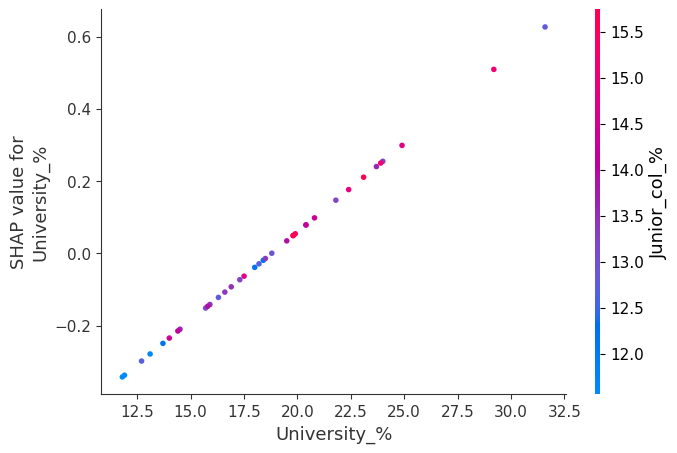

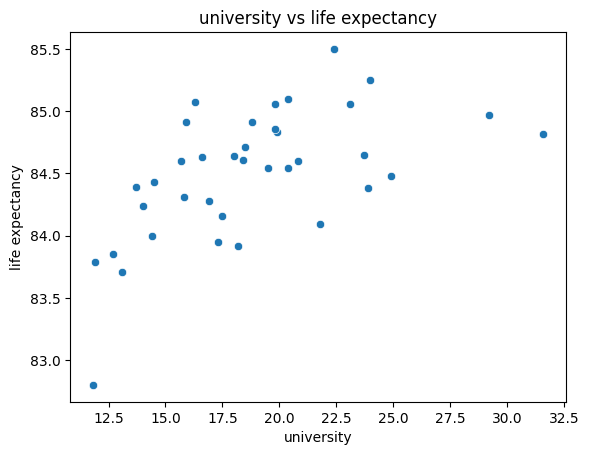

In [121]:
#SHAP
import shap
from sklearn.linear_model import LinearRegression
import seaborn as sns
#explain de model prediction using SHAP
X_train=pd.read_excel("~/Library/CloudStorage/OneDrive-国立大学法人東海国立大学機構/Weekly_challenges/Data science and Analytics/Japan_Life_Expectency/data/processed/X_train_best.xlsx")
y_train=pd.read_excel("~/Library/CloudStorage/OneDrive-国立大学法人東海国立大学機構/Weekly_challenges/Data science and Analytics/Japan_Life_Expectency/data/processed/y_train.xlsx")
explainer=shap.Explainer(model, X_train)
shap_values=explainer(X_train)
#summary plot
shap.summary_plot(shap_values, X_train)

shap_values_array=shap_values.values
#SHAP dependance plot to visualize interactions along with the most interacting feature
shap.dependence_plot("University_%", shap_values_array, X_train.values, feature_names=X_train.columns)
#Verify your hypothesis
y_train=y_train.squeeze()
sns.scatterplot(x=X_train["University_%"], y=y_train)
plt.title("university vs life expectancy")
plt.xlabel("university")
plt.ylabel("life expectancy")
plt.show() 


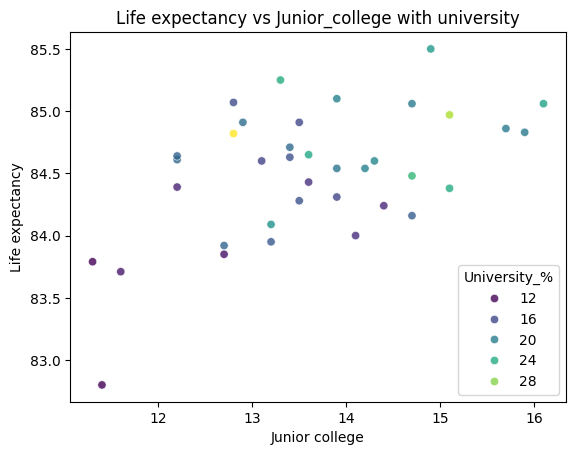

       University_%  Junior_col_%
count     37.000000     37.000000
mean      18.789189     13.627027
std        4.532769      1.200844
min       11.800000     11.300000
25%       15.800000     12.800000
50%       18.400000     13.500000
75%       20.800000     14.400000
max       31.600000     16.100000
Junior_col_%
Low     21
High    16
Name: count, dtype: int64
University_%
Low     28
High     9
Name: count, dtype: int64
  Junior_col_% University_%  Life_expectancy
0          Low          Low        84.305882
1          Low         High        84.702500
2         High          Low        84.567273
3         High         High        84.878000
University_%        Low     High
Junior_col_%                    
Low           84.305882  84.7025
High          84.567273  84.8780


/var/folders/67/30n6r04x5tv_vpf5gf2t8t_80000gn/T/ipykernel_97782/811716122.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby(['Junior_col_%', 'University_%']).mean().reset_index()


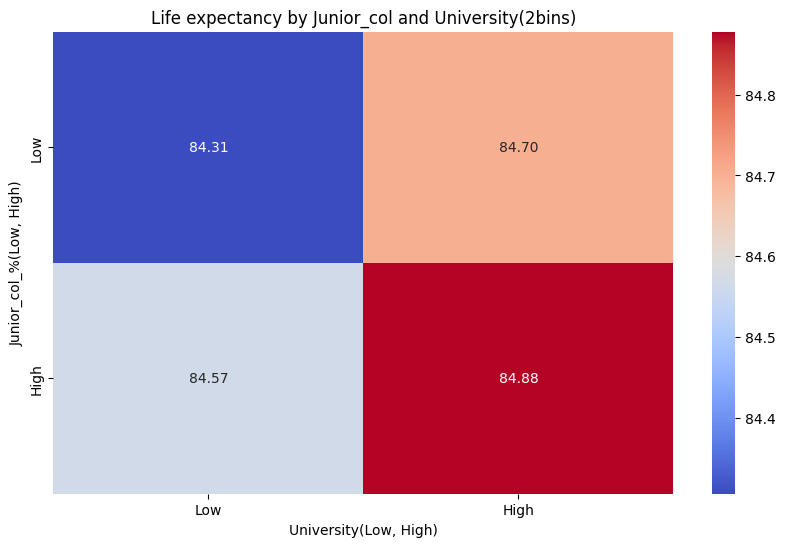

In [130]:
#Interpretation
#scatter plot: Junior college vs life expectancy with university % as color
sns.scatterplot(x='Junior_col_%', y=y_train, hue="University_%", palette='viridis', alpha=0.8, data=X_train)
plt.title('Life expectancy vs Junior_college with university')
plt.xlabel('Junior college')
plt.ylabel('Life expectancy')
plt.show()
#Heatmap: group data into 2 bins (High/Low) 
print(X_train.describe())
#Bin salary_log and university_% into 2 categories: Low, High
Junior_bins=pd.cut(X_train['Junior_col_%'], bins=2, labels=['Low', 'High'])
university_bins=pd.cut(X_train['University_%'], bins=2, labels=['Low', 'High'])
print(f"{Junior_bins.value_counts()}\n{university_bins.value_counts()}")

#create a pivot table for heatmap
heatmap_data=pd.DataFrame({
    'Junior_col_%': Junior_bins,
    'University_%': university_bins,
    'Life_expectancy': y_train
}).groupby(['Junior_col_%', 'University_%']).mean().reset_index()
print(heatmap_data)

#pivot data for heatmap
heatmap_pivot=heatmap_data.pivot(index='Junior_col_%', columns='University_%', values='Life_expectancy')
print(heatmap_pivot)

#plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_pivot, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Life expectancy by Junior_col and University(2bins)")
plt.xlabel('University(Low, High)')
plt.ylabel('Junior_col_%(Low, High)')
plt.show()


In [ ]:
# Test binning with 2, 3, or 4 bins for junior_col_%
for bins in [2, 3, 4]:
    salary_bins = pd.cut(X_train['Junior_col_%'], bins=bins, labels=['Bin ' + str(i) for i in range(1, bins + 1)])
    print(f"Binning with {bins} bins:")
    print(salary_bins.value_counts())

# Test binning for University_%
for bins in [2, 3, 4]:
    university_bins= pd.cut(X_train['University_%'], bins=bins, labels=['Bin ' + str(i) for i in range(1, bins + 1)])
    print(f"Binning with {bins} bins:")
    print(university_bins.value_counts())


# Observations from feature_engineering
`Coef_magnitude`:
- `University_%` ,`Junior_college_%`,have both positive coefficients (0.13 and 0.05) so they impact `Life_expectancy` positively 
with `University_%` having a bigger impact
`SHAP`: 
- `University_%` and `Junior_college_%` have both significant impact on predicting `Life_expectancy` 
- Higher Values for `University_%`,`Junior_col_%`Increases `Life_expectancy` while lower values Decrease it
- `Shap_dependance_plot` shows that areas with lower university completion and lower Junior col completion have low life expectancy (Blue dots)while areas with higher university completion and higher Junior college completion (Red dots) have higher life expectancy
  * Hypothesis: Areas with High university and junior college completion levels are most probably Urban areas and have high life expectancy while rural areas are low education low salary areas and have lower life expectancy (Correlation not causation further evidence is needed)
  * Validation: 
    - Add regional feature (urban/ rural) to include in analysis and include stress metrics (Cluster prefectures by Rural/Urban category before performing a linear regression)
    - Data Binning: to identify the correlation between education and life expectancy we segmented the data into Low/High bins using a heatmap dataframe. Data reveals that a higher education consistently improves life expectancy while lower education has a negative impact on life expectancy. 